In [38]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle
import random
import os
from torchvision import transforms

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import sys
sys.path.append('../code')
from python.commons import full_inference_e2e, inc_inference_e2e, inc_inference_e2e_with_model, generate_heatmap, load_dict_from_hdf5
from python.imagenet_classes import class_names
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

random.seed(45)
np.random.seed(45)

torch.set_num_threads(8)

# image_file_path = "../data/oct/test/DME/DME-119840-17.jpeg"
# image_file_path = "../data/oct/test/CNV/CNV-9734808-3.jpeg"
# image_file_path = "../data/oct/validation/DRUSEN/DRUSEN-5333808-1.jpeg"

################################################
###
###  Used for pannel Plot
###  VGG16, Patch Size: 4, Stride 1, C=0.0
###
################################################
image_file_path = "../data/oct/test/DME/DME-5245128-3.jpeg"
# image_file_path = "../data/chest_xray/test/VIRAL/person1110_virus_1835.jpeg"
# image_file_path = "/home/snakanda/Work/Krypton/data/imagenet-sample/n03838899_27257_oboe.jpg"
# image_file_path = "/home/snakanda/Work/Krypton/exps/fireboat.png"
# image_file_path = "/home/snakanda/Work/Krypton/camera.png"
# image_file_path = "../code/python/dog_resized.jpg"

In [50]:
model = ResNet18
patch_size = 16
stride = 4
c = 0
dataset = 'oct'

if model == Inception3:
    image_size = 299
else:
    image_size = 224
gpu = True

In [51]:
if dataset != "imagenet":
    weight_files = {
        VGG16 : '../code/python/vgg16_weights_ptch.h5',
        ResNet18 : '../code/python/resnet18_weights_ptch.h5',
        Inception3 : '../code/python/inception3_weights_ptch.h5'
    }

    fine_tuned_weight_files = {
        VGG16 : './'+dataset+'_vgg16_ptch.h5',
        ResNet18 : './'+dataset+'_resnet18_ptch.h5',
        Inception3 : './'+dataset+'_inception3_ptch.h5'
    }

    weights_data = load_dict_from_hdf5(weight_files[model], gpu=gpu)

    
    file_tuned_weight_data = load_dict_from_hdf5(fine_tuned_weight_files[model], gpu=gpu)
    
    if model == VGG16:
        weights_data['fc8_W:0'] = file_tuned_weight_data['fc8_W:0']
        weights_data['fc8_b:0'] = file_tuned_weight_data['fc8_b:0']
    elif model == ResNet18:
        weights_data['fc:w'] = file_tuned_weight_data['fc:w']
        weights_data['fc:b'] = file_tuned_weight_data['fc:b']
    elif model == Inception3:
        weights_data['482.fc.weight'] = file_tuned_weight_data['482.fc.weight']
        weights_data['483.fc.bias'] = file_tuned_weight_data['483.fc.bias']

else:
    weights_data = None

In [52]:
# import os

# for file_name in os.listdir('../data/oct/test/DME'):
#     image_file_path = '../data/oct/test/DME/'+file_name
#     if gpu:
#         torch.cuda.synchronize()

#     prev_time = time.time()
#     with torch.no_grad():
#         x, prob, logit_index = full_inference_e2e(model, image_file_path, patch_size, stride,
#                                batch_size=32, gpu=gpu, image_size=image_size, x_size=image_size,
#                                y_size=image_size, weights_data=weights_data, c=c)

#     if gpu:
#         torch.cuda.synchronize()

#     full_inference_time = time.time() - prev_time
#     print("Full Inference Time: " + str(full_inference_time) + "    Prob:" + str(prob) + "    Label:" + str(logit_index))
#     if prob > 0.8:
#         print(image_file_path)


# for file_name in os.listdir("/home/snakanda/Work/Krypton/data/imagenet-sample"):
#     image_file_path = "/home/snakanda/Work/Krypton/data/imagenet-sample/"+file_name
torch.cuda.synchronize()
prev_time = time.time()
with torch.no_grad():
    x, prob, logit_index = full_inference_e2e(model, image_file_path, patch_size, stride,
                           batch_size=128, gpu=gpu, image_size=image_size, x_size=image_size,
                           y_size=image_size, weights_data=weights_data, c=c)

if gpu:
    torch.cuda.synchronize()

torch.cuda.synchronize()
full_inference_time = time.time() - prev_time

print("Full Inference Time: " + str(full_inference_time) + "    Prob:" + str(prob) + "    Label:" + str(logit_index))
# print(image_file_path)
# orig_hm  =  generate_heatmap(image_file_path, x, show=True, width=image_size, alpha=1.0, prob=prob)

Full Inference Time: 1.50376605988    Prob:0.95198995    Label:2


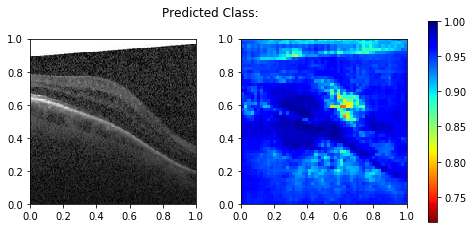

In [53]:
orig_hm  =  generate_heatmap(image_file_path, x, show=True, width=image_size, alpha=1.0, prob=prob)

output = open('temp', 'w')
pickle.dump(orig_hm, output)
output.close()

In [54]:
def inc_inference_selected_with_model(inc_model, file_path, patch_size, stride, patch_positions, batch_size=64, beta=1.0,
                           x0=0, y0=0, image_size=224, x_size=224, y_size=224, gpu=True, version='v1',
                           n_labels=1000, weights_data=None, loader=None, c=0.0):

    if loader == None:
        loader = transforms.Compose([transforms.Resize([image_size, image_size]), transforms.ToTensor()])
    orig_image = Image.open(file_path).convert('RGB')
    orig_image = loader(orig_image).unsqueeze(0)

    if gpu:
        orig_image = orig_image.cuda()

    image_patches = torch.FloatTensor(3, patch_size, patch_size).fill_(c).repeat(batch_size, 1, 1, 1)
        
    x_output_width = int(math.ceil((x_size*1.0 - patch_size) / stride))
    y_output_width = int(math.ceil((y_size*1.0 - patch_size) / stride))

    total_number = x_output_width * y_output_width
    logit_values = np.zeros((x_output_width, y_output_width), dtype=np.float32)
    
    num_batches = int(math.ceil(len(patch_positions) * 1.0 / batch_size))
    #inc_model = model(beta=beta, gpu=gpu, n_labels=n_labels, weights_data=weights_data).eval()
    
    if gpu:
        inc_model = inc_model.cuda()
        
    temp = inc_model.forward_materialized(orig_image).cpu().data.numpy()
    logit_index = np.argmax(temp)
    prob = np.max(temp)
 
    locations = torch.zeros([batch_size, 2], dtype=torch.int32)
    
    for i in range(num_batches):
        for j in range(batch_size):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break

            x, y = patch_positions[index]
            x = x*stride + x0
            y = y*stride + y0
            x,y = int(x), int(y)
            
            locations[j, 0] = x
            locations[j, 1] = y

        if version == 'v1':
            logits = inc_model.forward_gpu(image_patches, locations, p_height=patch_size, p_width=patch_size)
        else:
            logits = inc_model.forward_pytorch(image_patches, locations, p_height=patch_size, p_width=patch_size)
            
        logits = logits.cpu().data.numpy()[:, logit_index].flatten().tolist()

        for logit, j in zip(logits, range(batch_size)):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break
            x, y = patch_positions[index]
            logit_values[x, y] = logit

    del inc_model
    gc.collect()

    return logit_values, prob, logit_index



def adaptive_drilldown(inc_model1, inc_model2, file_path, patch_size, stride, batch_size=128, image_size=224,
                       x_size=224, y_size=224, beta=1.0, percentile=25, gpu=True, version='v1',
                       n_labels=1000, weights_data=None, loader=None, c=0.0):
    final_out_width = int(math.ceil((image_size*1.0-patch_size)/stride))

    speedup = 3
    s1 = round(math.sqrt(speedup/(1-percentile/100.0*speedup))*stride)
    print(percentile, speedup, s1, stride)
    
    #checking for interested regions
    temp1, prob, logit_index = inc_inference_e2e_with_model(inc_model1, file_path, patch_size, s1,
                                    batch_size=batch_size, beta=beta, image_size=image_size, x_size=x_size,
                              y_size=y_size, gpu=gpu, version=version, weights_data=weights_data, loader=loader, c=c)

    temp1 = cv2.resize(temp1, (final_out_width, final_out_width), interpolation=cv2.INTER_LINEAR)
    threshold = np.percentile(temp1, percentile)
    temp1 = np.where(temp1 <= threshold, 0, temp1)
    idx = np.argwhere(temp1 <= threshold)
    
    #drilldown into interested regions
    temp2, prob, logit_index = inc_inference_selected_with_model(inc_model2, file_path, patch_size, stride, idx.tolist(),
                                    batch_size=batch_size, beta=beta, image_size=image_size,
                              x_size=image_size, y_size=image_size, gpu=gpu, version=version,
                            weights_data=weights_data, loader=loader, c=c)

    
    
    return np.add(temp1, temp2), prob, logit_index
    #return temp1, prob, logit_index


def inc_inference(inc_model1, inc_model2, beta, patch_size=4, stride=1, adaptive=False, weights_data=None):
    if gpu:
        torch.cuda.synchronize()
    
    if not adaptive:
        with torch.no_grad():
            x, prob, logit_index = inc_inference_e2e_with_model(inc_model1, image_file_path, patch_size, stride,
                                  batch_size=128, beta=beta, gpu=gpu, version='v1',
                                 image_size=image_size, x_size=image_size, y_size=image_size,
                                 weights_data=weights_data)
    else:
        with torch.no_grad():
            x, prob, logit_index = adaptive_drilldown(inc_model1, inc_model2, image_file_path, patch_size, stride,
                                    batch_size=128, beta=beta, gpu=gpu, version='v1', percentile=25,
                                  image_size=image_size, x_size=image_size, y_size=image_size,
                                  weights_data=weights_data)
    if gpu:
        torch.cuda.synchronize()

    return x, prob, logit_index

BETA: 1.0 Inference Time: 0.887562036514


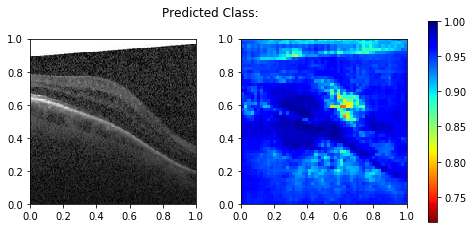

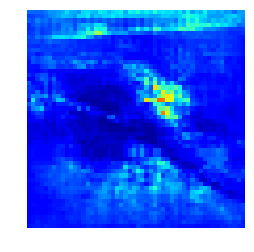

In [69]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

taus = [1.0]#[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]

inc_model1 = model(gpu=gpu, weights_data=weights_data).eval()
inc_model2 = model(gpu=gpu, weights_data=weights_data).eval()
for beta in taus:
    #warming up
    inc_model1 = model(gpu=gpu, beta=beta, weights_data=weights_data).eval()
    inc_model2 = model(gpu=gpu, beta=beta, weights_data=weights_data).eval()
    x, prob, logit_index = inc_inference(inc_model1, inc_model2, beta, patch_size=patch_size, stride=stride, adaptive=False,
                                         weights_data=weights_data)
    
    prev_time = time.time()
    x, prob, logit_index = inc_inference(inc_model1, inc_model2, beta, patch_size=patch_size, stride=stride, adaptive=False,
                                         weights_data=weights_data)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, width=224, alpha=1.0, prob=prob)
    
    if hm.shape[0] < 7:
        win_size=3
    else:
        win_size=None
    
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size))
    
    #clear
    plt.show()
    plt.axis('off')
    plt.imshow(hm)
    plt.savefig('temp'+str(beta)+'.jpg', bbox_inches='tight')
    plt.show()

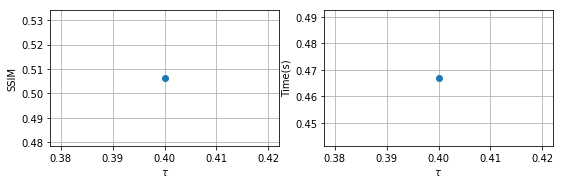

In [60]:
plt.figure(figsize=(9,2.5))

plt.subplot(1,2,1)
plt.plot(taus, score, marker='o')
plt.ylabel('SSIM')
plt.xlabel(r'$\tau$')
plt.grid()

plt.subplot(1,2,2)
plt.plot(taus, times, marker='o')
plt.ylabel('Time(s)')
plt.xlabel(r'$\tau$')
plt.grid()

plt.show()

In [11]:
score

[0.8433271604008179,
 0.8433267763426525,
 0.8433102379404168,
 0.8427808798156947,
 0.8371986617975565,
 0.8329554655219736,
 0.7764898666284193,
 0.543815126215457]

In [ ]:
#incremental 1.23177695274, imagenet: 0.533699989319, oct: 0.354171991348, chest_xray: 0.690973997116